### Importing required Utilities

In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

### Listing data and Dataframe creation

In [31]:
#path to data
path = 'C:/Users/Tommee Ellwyn Saljay/Desktop/Neural Networks/Data/'

#Training Images
train_norm = os.listdir(path + "Train/Normal")
train_covid = os.listdir(path + "Train/Covid")

#Testing Images
test_norm = os.listdir(path + "Test/Normal")
test_covid = os.listdir(path + "Test/Covid")

In [32]:
#Dataframe function
def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

#Forming Train and Test Dataframe
train_norm_df = dataframe(train_norm, 'Normal')
train_covid_df = dataframe(train_covid, 'Covid')

test_norm_df = dataframe(test_norm, 'Normal')
test_covid_df = dataframe(test_covid, 'Covid')

#Concating both classes into single datarame
train_df = pd.concat([train_norm_df, train_covid_df], axis=0)
test_df = pd.concat([test_norm_df, test_covid_df], axis=0)

In [33]:
#Path maker function
def pathmaker(df_name, df, empty_list):
    for i in df_name.values:
        if i[1] == 'Normal':
            empty_list.append(str(path + df + '/Normal/'+i[0]))
        else:
            empty_list.append(str(path + df + '/Covid/'+i[0]))


#Empty list to be passed in path maker
train_path = []
test_path = []

#Assigning Path maker
pathmaker(train_df, 'train', train_path)
pathmaker(test_df, 'test', test_path)

train_df['Path'] = train_path
test_df['Path'] = test_path

#Shuffling / Re-arranging rows
train_df = train_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]
test_df = test_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]

train_df.head()

,Class,Path
0,Covid,C:/Users/Tommee Ellwyn Saljay/Desktop/Neural N...
1,Normal,C:/Users/Tommee Ellwyn Saljay/Desktop/Neural N...
2,Normal,C:/Users/Tommee Ellwyn Saljay/Desktop/Neural N...
3,Covid,C:/Users/Tommee Ellwyn Saljay/Desktop/Neural N...
4,Normal,C:/Users/Tommee Ellwyn Saljay/Desktop/Neural N...


### Exploratory Data Analysis

Text(0.5, 1.0, 'COVID-19')

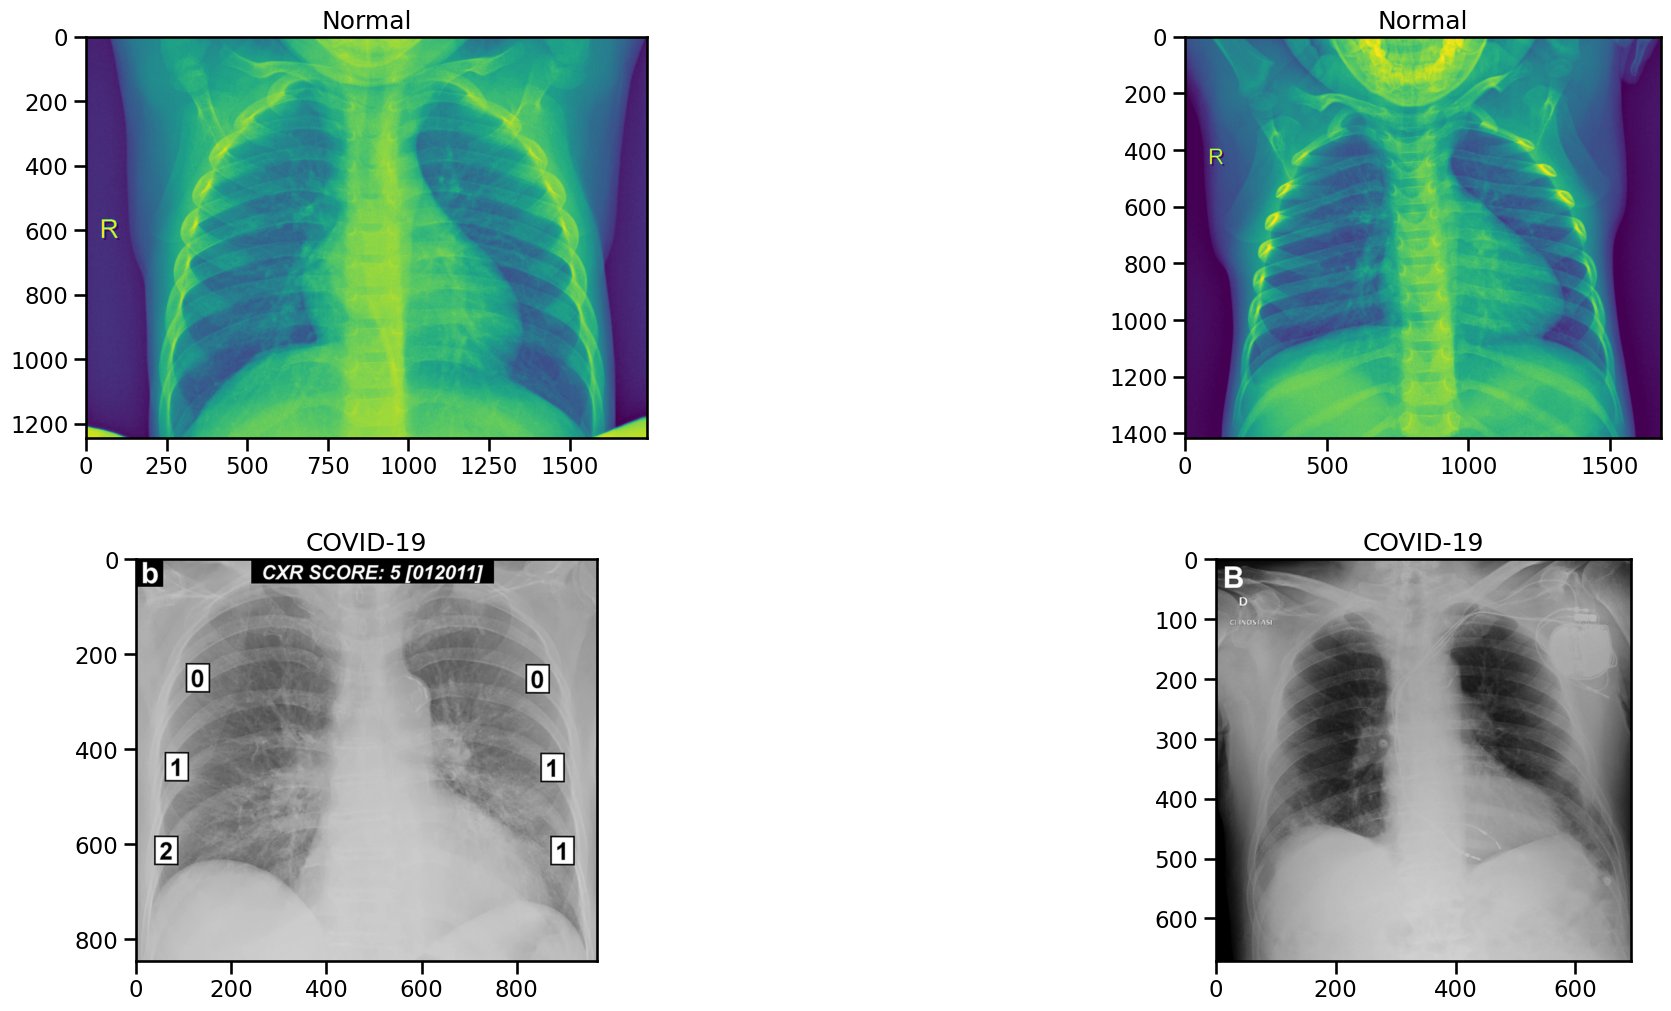

In [34]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(25,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[0]))
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[6]))
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[30]))
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[26]))
plt.title('COVID-19')

Text(0.5, 1.0, 'Category Count')

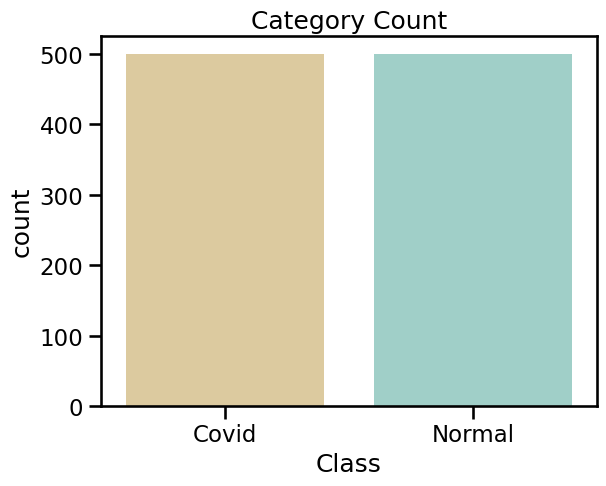

In [7]:
#Category count Plot
sns.countplot(train_df['Class'], palette='BrBG')
plt.title('Category Count')

### Image Processing

In [8]:
# Image to matrix function

def img_to_mtx(data, empty_array):
    for i in data:
        temp_img = image.load_img(i, target_size=(150,150))
        temp_img = img_to_array(temp_img)
        empty_array.append(temp_img)

#empty list
train_imgs = []
test_imgs = []

#Applying Image to Matrix
img_to_mtx(train_df['Path'], train_imgs)
img_to_mtx(test_df['Path'], test_imgs)

#keras preprocessing
train_imgs = preprocess_input(np.array(train_imgs))
test_imgs = preprocess_input(np.array(test_imgs))

### Label Encoding

In [9]:
#String to Numeric Label
train_df['Class'] = train_df['Class'].replace(['Covid','Normal'], [1,0])
test_df['Class'] = test_df['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output
ytrain = to_categorical(train_df['Class'], num_classes=2)

### Implementation of Early Stopping module & Saving Best Model Architecture

In [10]:
#Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

### Deep Neural Network - Implementing CNN

In [11]:
model = Sequential()

#Normalization & Input
model.add(BatchNormalization(input_shape=(150, 150, 3)))

#CNN
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Dropout(0.25))

#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
#overview of deep neural network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 flatten (Flatten)           (None, 180000)            0         
                                                                 
 dense (Dense)               (None, 128)               2

### Execution

In [13]:
#Model fitting and tracking historical accuracy / error score
history = model.fit(train_imgs, ytrain, 
          validation_split=0.10, 
          epochs=20, batch_size=32, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Epoch 1/20
29/29 [==============================] - 14s 455ms/step - loss: 1.6567 - accuracy: 0.9211 - val_loss: 0.7329 - val_accuracy: 0.9700
Epoch 2/20
29/29 [==============================] - 13s 465ms/step - loss: 0.2378 - accuracy: 0.9722 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 3/20
29/29 [==============================] - 13s 454ms/step - loss: 0.0181 - accuracy: 0.9967 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 4/20
29/29 [==============================] - 13s 433ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 5/20
29/29 [==============================] - 13s 450ms/step - loss: 0.0039 - accuracy: 0.9978 - val_loss: 0.0106 - val_accuracy: 0.9900
Epoch 6/20
29/29 [==============================] - 13s 463ms/step - loss: 8.4561e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 7/20
29/29 [==============================] - 13s 447ms/step - loss: 5.6916e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy

### Learning curve over Number of Iterations

Text(0, 0.5, 'Error')

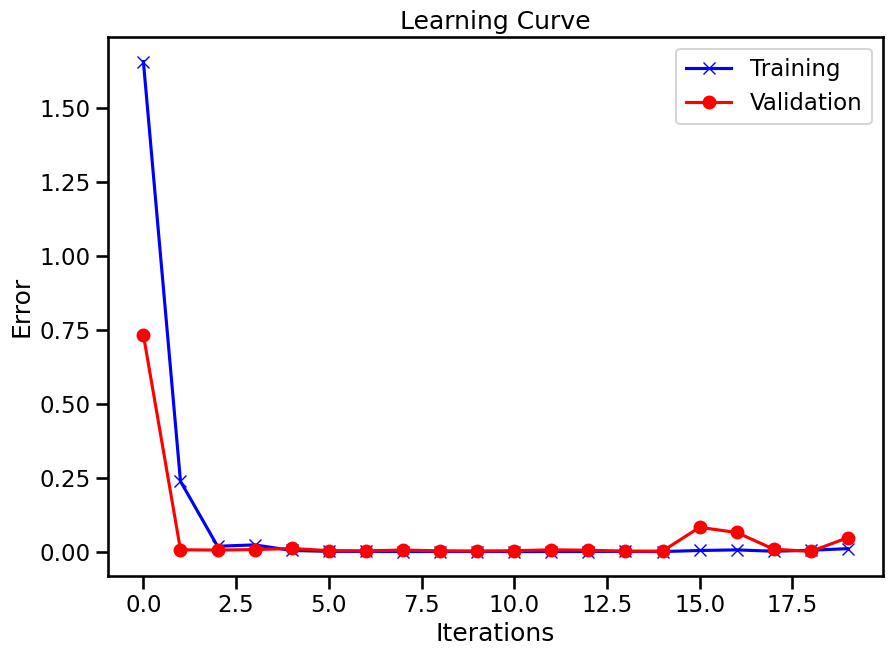

In [14]:
#plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

### Prediction

In [15]:
#prediction on test set
pred = model.predict(test_imgs, batch_size=32)
#pred

#converting Probabilities to labels
label = np.argmax(pred, axis=1)
#label

7/7 [==============================] - 0s 37ms/step


In [36]:
label

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0], dtype=int64)

### Performance Evaluation - Accuracy, Classification Report & Confusion Matrix

In [16]:
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, test_df['Class'].values), '\n')

#precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, test_df['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Text(0.5, 1.0, 'Confusion Matrix')

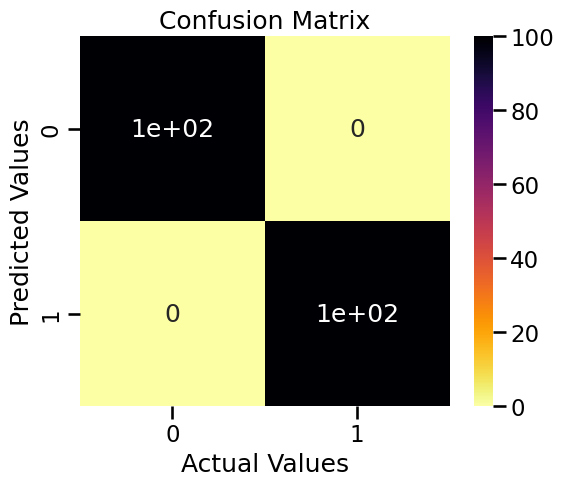

In [17]:
#plotting confusion matrix
sns.heatmap(confusion_matrix(label, test_df['Class'].values), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')